In [115]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

This is the final notebook for the  logistic regression analysis. Previous iterations are in the archive folder.

In [116]:
df = pd.read_csv('03-data/data.csv')
df.shape

(23524, 13)

In [117]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [118]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-118-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-118-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-118-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [120]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [121]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-121-4a08e3cd5a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-121-4a08e3cd5a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [122]:
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
y_tr.drop(columns='bank_account',inplace=True)

<ipython-input-122-dc6323112d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [123]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [124]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [125]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

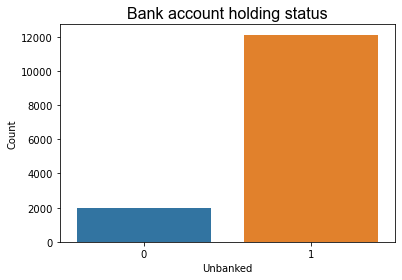

In [208]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Unbanked')
plt.ylabel('Count')
plt.show;

In [127]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [128]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [129]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

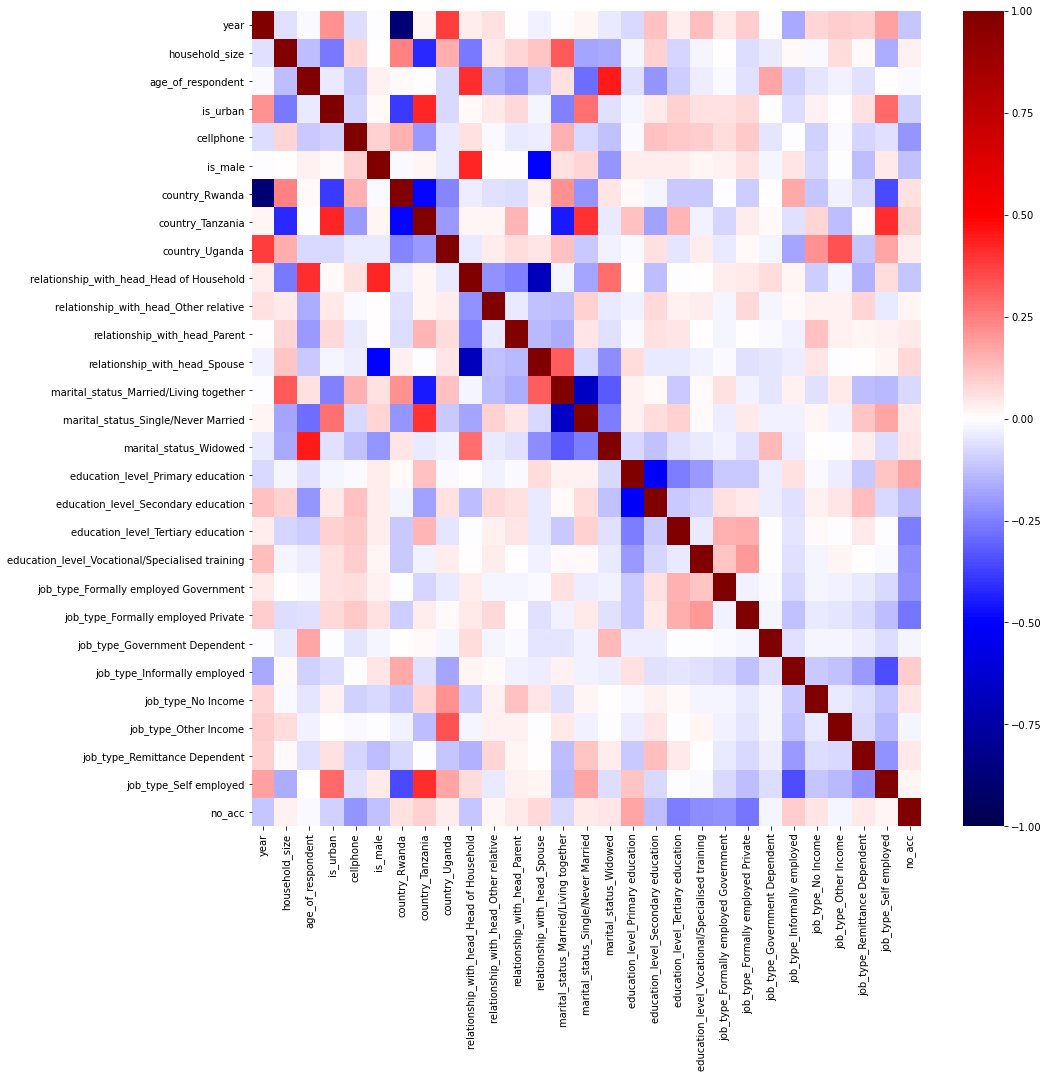

In [130]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

Note that some of these features are correlatedand shouldbe removed during analysis below

## Simple logistic regression

Testing with a single variable: is_male

In [131]:
#Model on is_male first
lm_1 = sm.Logit(df_train['no_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [132]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 no_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Feb 2021   Pseudo R-squ.:                 0.01691
Time:                        09:30:39   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1251      0.035     60.055      0.000       2.056       2.194
is_male       -0.6779      0.049    -13.887      0.000      -0.774      -0.582
==============================================================================
"""

In [133]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['no_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [134]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  2.1251
is_male coef:  -0.6779


In [135]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['no_acc']

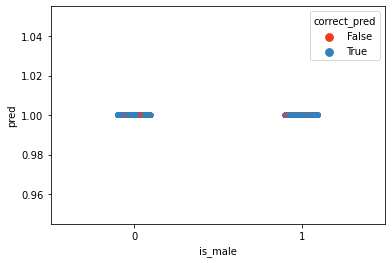

In [136]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [137]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.10668258, 0.89331742],
       [0.19044297, 0.80955703],
       [0.10668258, 0.89331742],
       [0.10668258, 0.89331742],
       [0.19044297, 0.80955703]])

In [138]:
confusion_matrix(df_eval['no_acc'], df_eval['pred'])

array([[   0,  492],
       [   0, 3037]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

In [139]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [140]:
lm_2 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_2.fit(df_train[features], df_train['no_acc'])

preds = lm_2.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(df_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [141]:
print('Feature coefficient results: \n')
for feature, coef in zip(df_train[features].columns, lm_2.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

household_size : -0.001
age_of_respondent : -0.013
is_urban : -0.271
cellphone : -1.629
is_male : -0.455
country_Rwanda : 0.337
country_Tanzania : 1.267
country_Uganda : 1.214
relationship_with_head_Head of Household : -0.796
relationship_with_head_Other relative : -0.120
relationship_with_head_Parent : -0.025
relationship_with_head_Spouse : -0.569
marital_status_Married/Living together : -0.035
marital_status_Single/Never Married : 0.128
marital_status_Widowed : -0.061
education_level_Primary education : -0.758
education_level_Secondary education : -1.760
education_level_Tertiary education : -3.231
education_level_Vocational/Specialised training : -2.770
job_type_Formally employed Government : -1.615
job_type_Formally employed Private : -1.723
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.363
job_type_No Income : 0.189
job_type_Other Income : -0.673
job_type_Remittance Dependent : 0.205
job_type_Self employed : -0.461


In [142]:
lm_2.intercept_

array([5.64670061])

In [143]:
df_val['preds'] = lm_2.predict(df_val[features])

In [144]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [145]:
y_prob = lm_2.predict_proba(df_val[features])

In [146]:
confusion_matrix(df_val['no_acc'], 
                 preds)

array([[ 168,  324],
       [  79, 2958]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 168 | 324|
| **is UNbanked (1)** | 79 | 2958 |

Need to understand and decide on the __trade off between recall and precision__

Precision is the number of observations predicted positive over the total actual positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the number of actually positive observations over the number predicted positive. The recall is intuitively the ability of the classifier to find all the positive samples.

In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



The model should optimise for recall given the importance of identifying the unbanked and understanding the most important features linked to being unbanked. Therefore, the recall for the positive class is quite good. However, precision is comparatively low meaning that banked individuals are being classified as unbanked. 

Precision and recall for negative class are much lower - again because many banked are being classified as unbanked

In [148]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val['no_acc'],
                                 df_val['proba_bank'])

In [149]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

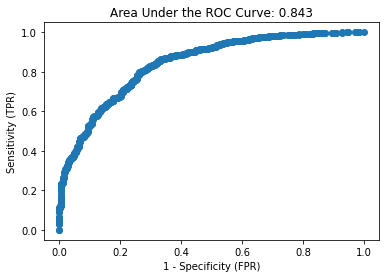

In [150]:
plot_roc(df_val['no_acc'], df_val['proba_bank'],fpr2,tpr2)

## Adjusting threshold

In [155]:
threshold = .55
y_pred = np.where((y_prob[:, 0] > threshold),0,1)

In [156]:
confusion_matrix(df_val['no_acc'], 
                 y_pred)

array([[ 149,  343],
       [  58, 2979]])

In [157]:
df_val['preds'] = np.where((y_prob[:, 0] > threshold),0,1)
df_comp = df_val[(df_val['no_acc'] != df_val['preds']) & (df_val['household_size'] ==1)]

In [158]:
print(classification_report(df_val['no_acc'], df_val['preds']))

              precision    recall  f1-score   support

           0       0.72      0.30      0.43       492
           1       0.90      0.98      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.81      0.64      0.68      3529
weighted avg       0.87      0.89      0.87      3529



As expected, improvement in prediction of the positive class but correct prediction of negative class declines

## Multiple regression removing unused features

#### Removing parent and other relative

In [159]:
x_train_9 = df_train.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

df_val_9 = df_val.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

features9 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [160]:
lm_9 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_9.fit(x_train_9[features9], x_train_9['no_acc'])

preds9 = lm_9.predict(df_val_9[features9])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_9.score(df_val_9[features9], df_val_9['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [161]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_9[features9].columns, lm_9.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.001
is_urban : -0.274
cellphone : -1.635
is_male : -0.456
country_Rwanda : 0.337
country_Tanzania : 1.264
country_Uganda : 1.208
relationship_with_head_Head of Household : -0.761
relationship_with_head_Spouse : -0.536
marital_status_Married/Living together : -0.036
marital_status_Single/Never Married : 0.131
marital_status_Widowed : -0.062
education_level_Primary education : -0.763
education_level_Secondary education : -1.764
education_level_Tertiary education : -3.234
education_level_Vocational/Specialised training : -2.776
job_type_Formally employed Government : -1.614
job_type_Formally employed Private : -1.731
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.359
job_type_No Income : 0.187
job_type_Remittance Dependent : 0.203
job_type_Other Income : -0.672
job_type_Self employed : -0.462


In [162]:
confusion_matrix(df_val_9['no_acc'], 
                 preds9)

array([[ 169,  323],
       [  78, 2959]])

In [163]:
print(classification_report(df_val_9['no_acc'], preds9))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



Very minor improvement in prediction of both positive and negative classes

#### Removing married / living together

In [164]:
x_train_10 = x_train_9.drop(columns='marital_status_Married/Living together')

df_val_10 = df_val_9.drop(columns='marital_status_Married/Living together')

features10 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [165]:
lm_10 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_10.fit(x_train_10[features10], x_train_10['no_acc'])

preds10 = lm_10.predict(df_val_10[features10])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_10.score(
    df_val_10[features10], df_val_10['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [166]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_10[features10].columns, lm_10.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
household_size : -0.002
is_urban : -0.274
cellphone : -1.631
is_male : -0.460
country_Rwanda : 0.338
country_Tanzania : 1.273
country_Uganda : 1.210
relationship_with_head_Head of Household : -0.767
relationship_with_head_Spouse : -0.549
marital_status_Single/Never Married : 0.156
marital_status_Widowed : -0.035
education_level_Primary education : -0.759
education_level_Secondary education : -1.760
education_level_Tertiary education : -3.229
education_level_Vocational/Specialised training : -2.771
job_type_Formally employed Government : -1.613
job_type_Formally employed Private : -1.729
job_type_Government Dependent : -1.211
job_type_Informally employed : 0.362
job_type_No Income : 0.191
job_type_Remittance Dependent : 0.205
job_type_Other Income : -0.671
job_type_Self employed : -0.461


In [167]:
confusion_matrix(df_val_10['no_acc'], 
                 preds10)

array([[ 169,  323],
       [  78, 2959]])

In [168]:
print(classification_report(df_val_10['no_acc'], preds10))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



No change in prediction

In [57]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

In [169]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[features10])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['no_acc'],
                                 df_val_10['proba_bank'])

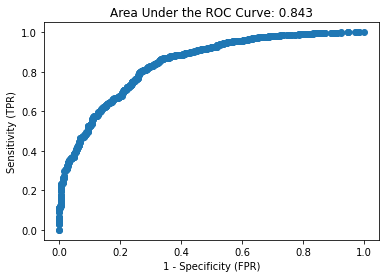

In [170]:
plot_roc(df_val_10['no_acc'], df_val_10['proba_bank'],fpr10,tpr10)

#### Removing household size

In [61]:
x_train_13 = x_train_10.drop(columns=['household_size','mean_hh'])

df_val_13 = df_val_10.drop(columns=['household_size','mean_hh'])

features13 = ['age_of_respondent','is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [62]:
lm_13 = LogisticRegression(C=1e13,penalty='l1',solver='liblinear')
lm_13.fit(x_train_13[features13], x_train_13['no_acc'])

preds13 = lm_13.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_13.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [63]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_13.columns, lm_13.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.273
cellphone : -1.642
is_male : -0.463
country_Rwanda : 0.335
country_Tanzania : 1.274
country_Uganda : 1.206
relationship_with_head_Head of Household : -0.767
relationship_with_head_Spouse : -0.552
marital_status_Single/Never Married : 0.155
marital_status_Widowed : -0.036
education_level_Primary education : -0.768
education_level_Secondary education : -1.769
education_level_Tertiary education : -3.237
education_level_Vocational/Specialised training : -2.779
job_type_Formally employed Government : -1.615
job_type_Formally employed Private : -1.731
job_type_Government Dependent : -1.213
job_type_Informally employed : 0.359
job_type_No Income : 0.188
job_type_Other Income : 0.200
job_type_Remittance Dependent : -0.673
job_type_Self employed : -0.464


In [173]:
print('Intercept:', lm_13.intercept_)

Intercept: [5.62368297]


In [67]:
confusion_matrix(df_val_13['no_acc'], 
                 preds13)

array([[ 169,  323],
       [  78, 2959]])

In [174]:
print(classification_report(df_val_13['no_acc'], preds13))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [175]:
df_val_13['proba_bank'] = lm_13.predict_proba(df_val_13[features13])[:, 1]

fpr13, tpr13, thresholds13 = roc_curve(df_val_13['no_acc'],
                                 df_val_13['proba_bank'])

In [176]:
df_val_13['preds'] = lm_13.predict(df_val_13[features13])
df_check = df_val_13[(df_val_13['no_acc'] != df_val_13['preds']) & (df_val_13['proba_bank'] >= 0.65)]

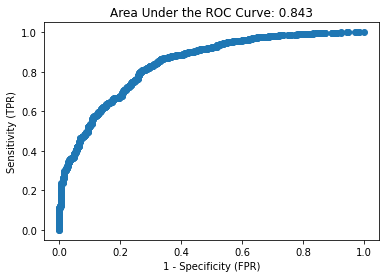

In [177]:
plot_roc(df_val_13['no_acc'], df_val_13['proba_bank'],fpr13,tpr13)
#plt.savefig("roc13.svg")

In [183]:
rw_wrong = len(df_check[df_check['country_Rwanda']==1]) / len(df_check)
tz_wrong = len(df_check[df_check['country_Tanzania']==1]) / len(df_check)
ug_wrong = len(df_check[df_check['country_Uganda']==1]) / len(df_check)
ke_wrong = 1 - rw_wrong - tz_wrong - ug_wrong
print("Rwanda wrong:{:0.3f} \nTanzania wrong: {:0.3f} \nUganda wrong:{:0.3f} \nKenya wrong:{:0.3f}".format(rw_wrong,tz_wrong,ug_wrong,ke_wrong))

Rwanda wrong:0.372 
Tanzania wrong: 0.242 
Uganda wrong:0.048 
Kenya wrong:0.338


The majority of the highly confident, incorrect predictions are in Rwanda (37%) and Kenya (33%). Review Tableau dashboard to identify common features linked to highly confident, false predictions.

#### Oversampling with model 13 features

In [184]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x_train_13[features13], x_train_13['no_acc'])

In [185]:
from collections import Counter
Counter(y_resampled)

Counter({1: 12128, 0: 12128})

In [186]:
lm_15 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_15.fit(X_resampled[features13], y_resampled)

preds15 = lm_15.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.791


In [187]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_resampled.columns, lm_15.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.013
is_urban : -0.226
cellphone : -1.697
is_male : -0.495
country_Rwanda : 0.423
country_Tanzania : 1.405
country_Uganda : 1.406
relationship_with_head_Head of Household : -0.661
relationship_with_head_Spouse : -0.434
marital_status_Single/Never Married : 0.184
marital_status_Widowed : -0.106
education_level_Primary education : -0.801
education_level_Secondary education : -1.794
education_level_Tertiary education : -3.254
education_level_Vocational/Specialised training : -2.885
job_type_Formally employed Government : -1.727
job_type_Formally employed Private : -1.778
job_type_Government Dependent : -1.439
job_type_Informally employed : 0.334
job_type_No Income : 0.138
job_type_Remittance Dependent : 0.185
job_type_Other Income : -0.682
job_type_Self employed : -0.547


In [188]:
confusion_matrix(df_val_13['no_acc'], 
                 preds15)

array([[ 354,  138],
       [ 601, 2436]])

In [189]:
print(classification_report(df_val_13['no_acc'], preds15))

              precision    recall  f1-score   support

           0       0.37      0.72      0.49       492
           1       0.95      0.80      0.87      3037

    accuracy                           0.79      3529
   macro avg       0.66      0.76      0.68      3529
weighted avg       0.87      0.79      0.82      3529



As expected, improved prediction of the minority class but worse prediction of the majority (positive) class. 

# Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [190]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-190-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-190-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-190-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [191]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [192]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-192-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-192-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [193]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [194]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [195]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-195-41dba9f5dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Testing the model on the test sample

#### Model 1 - all features

In [196]:
preds1_test = lm_2.predict(df_test[features])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_2.score(df_test[features], df_test['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.882


In [197]:
confusion_matrix(df_test['no_acc'], 
                 preds1_test)

array([[ 290,  544],
       [ 149, 4898]])


| | predict banked (0) | predict unbanked (1)|
|---|---|---|
| **is banked (0)** | 290 | 544|
| **is UNbanked (1)** | 149 | 4898 |

In [198]:
print(classification_report(df_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.87      0.88      0.87      5881



Consistent performance across validation and test

#### Multiple regression with model 13

In [199]:
df_test_13 = df_test.copy()

In [200]:
preds13_test = lm_13.predict(df_test_13[features13])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_13.score(df_test_13[features13],df_test_13['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.882


In [201]:
confusion_matrix(df_test_13['no_acc'], 
                 preds13_test)

array([[ 290,  544],
       [ 149, 4898]])

In [202]:
print(classification_report(df_test_13['no_acc'], preds13_test))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.87      0.88      0.87      5881



Model is broadly consistent across train - val - test

In [203]:
df_test_13['proba_bank'] = lm_13.predict_proba(df_test_13[features13])[:, 1]

fpr13_test, tpr13_test, thresholds13_test = roc_curve(df_test_13['no_acc'],
                                 df_test_13['proba_bank'])

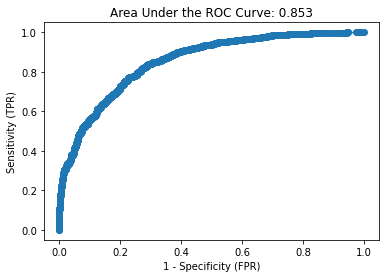

In [204]:
plot_roc(df_test_13['no_acc'], df_test_13['proba_bank'],fpr13_test,tpr13_test)

In [205]:
df_test_13['preds'] = lm_13.predict(df_test_13[features13])

In [206]:
final_test = pd.concat([df_test_13,x_test_cat],axis=1)

In [207]:
# Send to csv for visualisation in Tableau
final_test.to_csv('test_preds.csv')